In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib
import os
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt

c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


# Import des données

In [2]:
path_data = r"C:\Users\hp\Documents\MITSIOMOTU\Prise phase2\2. Data\1. Analyse cas d'usage\MMRE"

## Import des données de la CEET
# Réseaux et branchements BT
support_bt_ceet = gpd.read_file(os.path.join(path_data,'MEN','MEN','BT_Support_20240102.shp'))
support_bt_ceet = support_bt_ceet.to_crs(epsg='25231')
ligne_bt_ceet = gpd.read_file(os.path.join(path_data,'MEN','MEN','BT_Troncon_20240102.shp'))
ligne_bt_ceet = ligne_bt_ceet.to_crs(epsg='25231')
branchements_bt_ceet = gpd.read_file(os.path.join(path_data,'MEN','MEN','branchement_copie.gpkg'))
branchements_bt_ceet = branchements_bt_ceet.to_crs(epsg='25231')


# Import des données de PRISE
support_bt_prise = gpd.read_file(os.path.join(path_data,'ener_poteaux_bt.gpkg'))
support_bt_prise = support_bt_prise.to_crs(epsg='25231')
ligne_bt_prise = gpd.read_file(os.path.join(path_data,'ener_lignes_bt.gpkg'))
ligne_bt_prise.to_crs(epsg='25231')

# Import des limites administratives
cantons = gpd.read_file(os.path.join(path_data,'14_11_22_Togo_Cantons2_4326.gpkg'))
cantons = cantons.to_crs(epsg='25231')

# Import des données de concessions
concession_1 = gpd.read_file(os.path.join(path_data,'RGPH5_CARTO_Maritimes_Concessions1.gpkg'))
concession_2 = gpd.read_file(os.path.join(path_data,'RGPH5_CARTO_DAGL_Concessions1.gpkg'))
concession = pd.concat([concession_1 , concession_2]).reset_index()
concession = concession.to_crs(epsg='25231')

reg = 'Maritime'

In [3]:
# Branchements manquants Maritime
branchement_manquant_1 = gpd.read_file(os.path.join(path_data,'COMPLEMENT SHAPEFILES','Branchements_manquants.shp'))
branchement_manquant_2 = gpd.read_file(os.path.join(path_data,'drive-download-20250207T112419Z-001','Branchements_manquants_Golfe_Agoe.shp'))
branchement_manquant = pd.concat([branchement_manquant_1,branchement_manquant_2]).reset_index()
branchement_manquant = branchement_manquant.to_crs(epsg='25231')

# Convertir les lignes en points en prenant leur centroïde
branchements_bt_ceet["geometry"] = branchements_bt_ceet["geometry"].centroid

# Fusionner les GeoDataFrame
branchements_agg = pd.concat([branchement_manquant[['ID2',"geometry"]], branchements_bt_ceet[['longueur2d',"geometry"]]], ignore_index=True)

branchements_agg

,ID2,geometry,longueur2d
0,2802309.0,POINT (309987.929 691254.796),NaN
1,2942484.0,POINT (282766.282 692792.695),NaN
2,2942485.0,POINT (282766.866 692793.228),NaN
3,2942486.0,POINT (282767.315 692792.172),NaN
4,2942487.0,POINT (282767.170 692792.410),NaN
...,...,...,...
555703,NaN,POINT (235820.841 839525.639),89.580126
555704,NaN,POINT (286052.254 823808.487),15.073696
555705,NaN,POINT (297728.448 829494.336),21.319825
555706,NaN,POINT (325586.351 819329.067),3.646043


In [4]:
## Concaténation avec le réseau de Maritime
# Lignes manquantes Maritim
ligne_bt_manquant_1 = gpd.read_file(os.path.join(path_data,'COMPLEMENT SHAPEFILES','Reseau_BT_manquant.shp'))
ligne_bt_manquant_2 = gpd.read_file(os.path.join(path_data,'drive-download-20250207T112419Z-001','bt_corriges_par_rapport_aux_branchements_manquants.gpkg'))
ligne_bt_manquant = pd.concat([ligne_bt_manquant_1,ligne_bt_manquant_2]).reset_index()
ligne_bt_manquant = ligne_bt_manquant.to_crs(epsg='25231')

ligne_bt = pd.concat([ligne_bt_ceet,ligne_bt_manquant]).reset_index()



Import des données des ménages

In [5]:
# Import des données des ménages
menage_1 = pd.read_csv(os.path.join(path_data,'Menages_DAGL.csv'))
menage_2 = pd.read_csv(os.path.join(path_data,'Menages_DAGL_suite.csv'))

menage_agg = pd.concat([menage_1 , menage_2]).reset_index()

# Créer des objets géométriques Point à partir des colonnes LONGITUDE et LATITUDE
geometry = [Point(xy) for xy in zip(menage_agg['LONGITUDE'], menage_agg['LATITUDE'])]

# Créer un GeoDataFrame avec le système de coordonnées initial (WGS84, EPSG:4326)
gdf = gpd.GeoDataFrame(menage_agg, geometry=geometry, crs="EPSG:4326")

# Reprojeter le GeoDataFrame en EPSG:25231
gdf = gdf.to_crs(epsg=25231)



C:\Users\hp\AppData\Local\Temp\ipykernel_9440\1592162409.py:3: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  menage_2 = pd.read_csv(os.path.join(path_data,'Menages_DAGL_suite.csv'))


# Nettoyage des données

In [ ]:
# Jointure des éléments avec les limites admin
concessions_canton = gpd.sjoin_nearest(concession,cantons,how='inner',max_distance=5000)
branchements_bt_ceet_canton = gpd.sjoin_nearest(branchements_agg,cantons,how='inner',max_distance=5000)
menages_canton = gpd.sjoin_nearest(gdf,cantons,how='inner',max_distance=5000)

poteaux_gdf = gpd.sjoin_nearest(support_bt_ceet,cantons,how='inner',max_distance=5000)
lignes_bt_gdf = gpd.sjoin_nearest(ligne_bt,cantons,how='inner',max_distance=5000)

In [19]:
# Filtrer les géométries nulles
branchements_gdf = branchements_bt_ceet_canton[branchements_bt_ceet_canton.geometry.notnull()]
branchements_gdf = branchements_gdf.drop(columns='index_right')

poteaux_gdf = poteaux_gdf[poteaux_gdf.geometry.notnull()]
lignes_bt_gdf = lignes_bt_gdf[lignes_bt_gdf.geometry.notnull()]
lignes_bt_gdf = lignes_bt_gdf [lignes_bt_gdf.geometry.length  <= 5000 ]

concession_gdf = concessions_canton[concessions_canton.geometry.notnull()]
concession_gdf=concession_gdf.drop(columns='index_right')

menage_gdf = menages_canton[menages_canton.geometry.notnull()]
menage_gdf = menage_gdf.drop(columns='index_right')

In [20]:
### Nettoyage des longueurs de branchemnts
# Suppression des linéaires avec une longueur supérieure à 1000 mètres
branchements_gdf = branchements_gdf[(branchements_gdf["longueur2d"] <= 1000) | (branchements_gdf["longueur2d"].isna())]

Générer des concessions manquantes lorsque un ménage existe mais pas la concession

In [32]:
# Créer des géométries pour les concessions associées aux ménages
menage_gdf["geometry_concession"] = menage_gdf.apply(
    lambda row: Point(row["LONGITUDE_CONCESSION"], row["LATITUDE_CONCESSION"]),
    axis=1,
)

# Convertir les géométries en GeoDataFrame
concessions_menage_gdf= gpd.GeoDataFrame(menage_gdf[['ID_HHFtth','TAILLE_MENAGE','geometry_concession']], geometry="geometry_concession", crs="EPSG:4326")
concessions_menage_gdf = concessions_menage_gdf.to_crs(epsg = '25231')

# Appliquer un buffer de 1 mm 
buffer_size = 0.001  # En mètres 

# Effectuer la jointure spatiale (concessions les plus proches pour chaque ménage)
joined = gpd.sjoin_nearest(
    concessions_menage_gdf,
    concession_gdf,
    how="left",
    max_distance=buffer_size,
    distance_col="distance_to_concession"
)

# Identifier les ménages sans concessions associées dans la tolérance du buffer
gdf_concessions_manquantes = joined[joined["distance_to_concession"].isna()]

col_concess_manquante = ['ID_HHFtth','TAILLE_MENAGE','geometry_concession']

gdf_concessions_missing = gpd.sjoin(gdf_concessions_manquantes[col_concess_manquante],cantons, how='inner',predicate="intersects")

gdf_concessions_missing.to_file('concessions_manquantes_GL.gpkg', driver="GPKG")



c:\Users\hp\anaconda3\envs\mm\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Cacul des résultats 

Buffer et extraction des données dans les zones tampon

In [13]:
# Fonction pour créer des tampons fusionnés pour un GeoDataFrame donné

def generate_and_merge_buffers(gdf, distances):
    """
    Crée des tampons pour un GeoDataFrame et fusionne les géométries pour chaque distance.
    """
    buffers = {distance: [] for distance in distances}
    
    for distance in distances:
        # Créer une zone tampon
        buffer = gdf.geometry.buffer(distance)
        buffers[distance].append(buffer.unary_union)  # Fusion des géométries de ce lot

    return buffers

In [14]:
# Définition des distances
distances = [60, 70, 80]

# Générer les tampons pour poteaux et lignes
poteaux_buffers = generate_and_merge_buffers(poteaux_gdf, distances)
lignes_buffers = generate_and_merge_buffers(lignes_bt_gdf, distances)

# Fusionner les tampons poteaux et lignes pour chaque distance
merged_buffers = []
for distance in distances:
    # Fusionner les buffers des poteaux et des lignes
    merged_geom = gpd.GeoSeries([poteaux_buffers[distance][0], lignes_buffers[distance][0]]).unary_union
    merged_buffers.append({"geometry": merged_geom, "buffer_distance": distance})

# Création du GeoDataFrame final
final_gdf = gpd.GeoDataFrame(merged_buffers, crs=poteaux_gdf.crs)

# Sauvegarder les résultats dans un GeoPackage
final_gdf.to_file("zones_tampon_2.gpkg", driver="GPKG", layer="buffers")

c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Extraction des données dans les zones tampons

In [16]:
branchements_categori = gpd.read_file(os.path.join(path_data , 'script','branchements_categorises__.gpkg'),layer ='branchements' )

In [15]:
gdf_concessions_missing = gpd.read_file(os.path.join(path_data,'script','concessions_manquantes_GL.gpkg'))
gdf_concessions_missing = gdf_concessions_missing.to_crs(epsg='25231')

combined_buffer = gpd.read_file(os.path.join(path_data,'script','zones_tampon_2.gpkg'))


Comptage du nombre de concessions, du nombre de ménages et de branchements dans le buffer

In [35]:
# Filtrer les tampons de 60 m uniquement
reg = 'Maritime'

#b = 120

# Distances des tampons
distances = [60,70,80]#, 70, 80, 90, 100,110,120]

# Initialiser un GeoDataFrame pour stocker les résultats consolidés
limites_admin_final = cantons[cantons['region_nom'] == reg].copy()

# Initialiser une liste pour les résultats CSV consolidés
csv_data = []

In [ ]:
for b in distances:
    buffer = combined_buffer[combined_buffer["buffer_distance"] == b].reset_index(drop=True)
    buffer = buffer.drop(columns=['index_left', 'index_right'], errors='ignore')

    #gdf_concessions_missing = gdf_concessions_missing.rename(columns={'geometry_concession': 'geometry'})

    # Fusionner les deux GeoDataFrames (concessions_gdf et concessions_manquantes) en conservant les champs de concessions_gdf
    #concessions_total = pd.concat(concession_gdf, ignore_index=True)
    concessions_total = pd.concat([concession_gdf, gdf_concessions_missing], ignore_index=True)
    concessions_total = concessions_total.drop(columns=['index_left', 'index_right'], errors='ignore')
    concessions_total = gpd.GeoDataFrame(concessions_total, geometry='geometry', crs=concession_gdf.crs).reset_index(drop=True)


    # Concessions dans le buffer
    concessions_in_buffer = gpd.sjoin(concessions_total, buffer, how="inner", predicate="within")
    concess_colonne = ['N_REGION', 'N_PREFECTURE', 'N_COMMUNE', 'N_CANTON', 'MILIEU', 'TAILLE', 
        'region_nom', 'prefecture_nom', 'commune_nom', 'canton_nom', 'buffer_distance']
    
    concess_buff_cant = concessions_in_buffer[concess_colonne].groupby('canton_nom').size().rename(f"nb_concessions_{b}m")


    # Branchements dans la région actuelle
    branchement_buff = branchements_gdf[branchements_gdf['region_nom'] == reg].groupby('canton_nom').size().rename(f"nb_branchements_{b}m")
 
    # Ménages
    menages_in_buffer = gpd.sjoin(menage_gdf, buffer, how="inner", predicate="within")
    menage_colonne = ['N_REGION','N_PREFECTURE','N_COMMUNE','N_CANTON','MILIEU','TAILLE_MENAGE','region_nom','prefecture_nom','commune_nom','canton_nom','buffer_distance']
    menages_buffer_cant =  menages_in_buffer[menage_colonne].groupby('canton_nom').size().rename("nb_menages")

    # Fusion des statistiques avec le GeoDataFrame des limites administratives
    limites_admin_temp = limites_admin_final.copy()
    limites_admin_temp = limites_admin_temp.merge(concess_buff_cant, on="canton_nom", how="left")
    limites_admin_temp = limites_admin_temp.merge(branchement_buff, on="canton_nom", how="left")
    limites_admin_temp = limites_admin_temp.merge(menages_buffer_cant, on="canton_nom", how="left")    


    colonnes_a_ajouter = ["nb_concessions", "nb_branchements"]

    # Sauvegarder le GeoDataFrame final dans un GeoPackage
    output_gpkg = f"limites_admin_stats_{reg}_{b}_menage.gpkg"
    limites_admin_temp.to_file(output_gpkg, driver="GPKG")

# Sauvegarder les données consolidées dans un CSV
    output_csv = f"limites_admin_stats_{reg}_{b}_menage.xlsx"
    limites_admin_temp.to_excel(output_csv, index=False)



c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
c:\Users\hp\anaconda3\envs\mm\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Analyse de la distance entre un ménage connecté et le plus proche poteau BT

In [54]:
# Filtrer les ménages en fonction de la valeur du champ 'H08_Impute'
filtered_menages = menages_in_buffer[menages_in_buffer["H08_Impute"].isin([    "Electricité (CEET) compteur dans la concession" ]   ) ]

poteau_jointure = poteaux_gdf[['id_support','geometry']]

# Utilisation de sjoin_nearest pour trouver le support BT le plus proche
# Cette opération va joindre chaque ménage avec le poteau le plus proche et calculer la distance
nearest_poteaux = gpd.sjoin_nearest(
    filtered_menages[['ID_HHFtth','ID_RGPH','geometry']], 
    poteau_jointure, 
    how="left", 
    distance_col="distance_to_nearest_support",  # Ajouter une colonne pour la distance
    max_distance=None  # On peut spécifier une distance maximale, sinon laisser None pour tout considérer
)

# Extraire les distances
distances = nearest_poteaux['distance_to_nearest_support']


#print(f"Percentiles des distances : 0.9 = {percentiles[0]}, 0.95 = {percentiles[1]}, 0.99 = {percentiles[2]}")


In [59]:
# Calcul des percentiles 0.9, 0.95, 0.99
percentiles = np.round(np.percentile(distances, [50, 60,  75, 80, 84, 90, 95]),1)
percentiles

array([ 26.5,  32.5,  46.4,  53.5,  61.4,  81.8, 116.3])

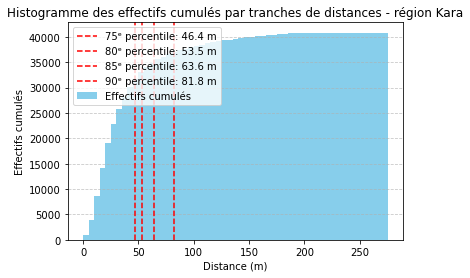

In [62]:
import matplotlib.pyplot as plt


# Créer les tranches de distances (par pas de 5 mètres)
bins = np.arange(0, distances.max() + 5, 5)  # Tranches de 5 mètres
hist, bin_edges = np.histogram(distances, bins=bins)  # Histogramme simple

# Calculer les effectifs cumulés
cumulative_effectifs = np.cumsum(hist)

# Calculer les percentiles
percentiles = [75, 80,85, 90]
percentile_values = np.percentile(distances, percentiles)

# Créer le graphique
plt.bar(bin_edges[:-1], cumulative_effectifs, width=5, align='edge', color='skyblue', label="Effectifs cumulés")

# Ajouter les lignes verticales pour les percentiles
for p, value in zip(percentiles, percentile_values):
    plt.axvline(value, color='red', linestyle='--', label=f"{p}ᵉ percentile: {value:.1f} m")

# Personnaliser le graphique
plt.title("Histogramme des effectifs cumulés par tranches de distances - région Kara")
plt.xlabel("Distance (m)")
plt.ylabel("Effectifs cumulés")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [46]:
# Calculer les percentiles
percentiles = [50,60,75, 80,84, 90]
percentile_values = np.percentile(distances, percentiles)
percentile_values 

array([ 33.26690457,  41.89897898,  59.7140481 ,  68.77389568,
        79.47473445, 102.46292449])